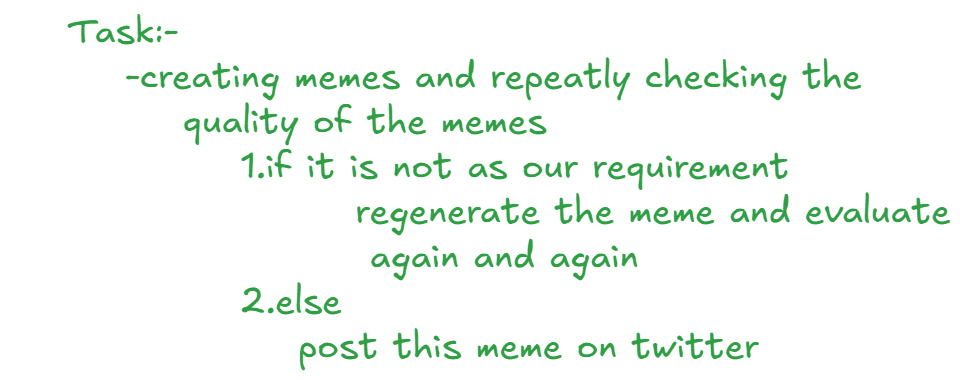

# <b>workflow that we will create


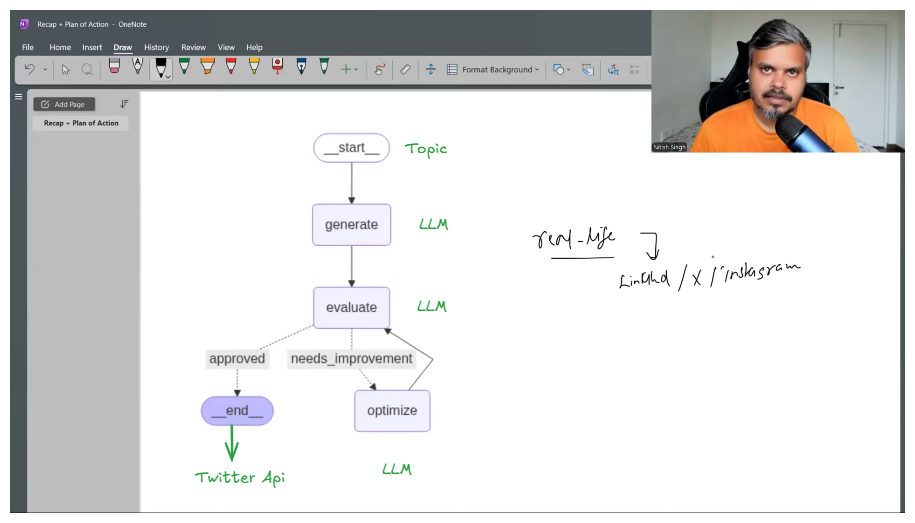

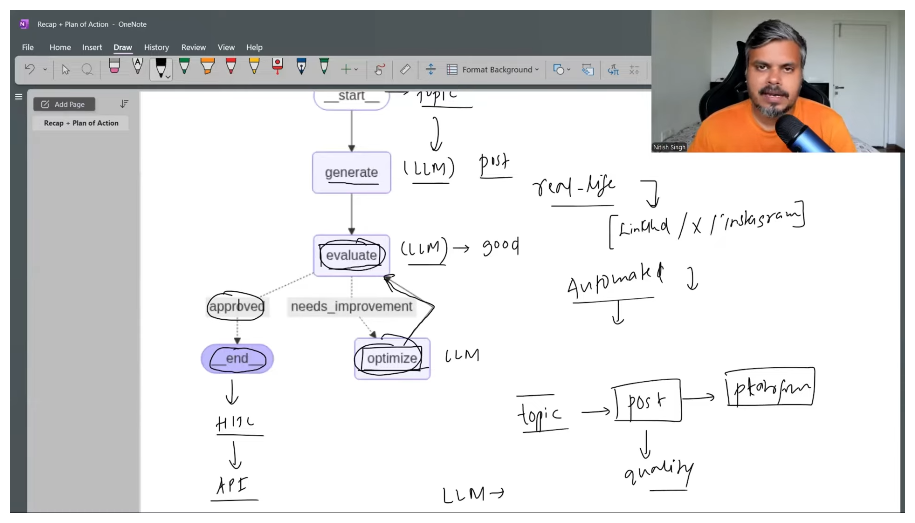

# <b>Step by step implementation of this workflow

step1:- improting all the libraries

In [75]:
# llm model implementation
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

# Load .env variables
load_dotenv()

# Load API key
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key  # Set it for LangChain usage

# Initialize Gemini model (text only)
# creating three different model for
generator_llm  = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
evaluator_llm  = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
optimizer_llm  = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


In [76]:
#  langchain and langgraph
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import operator

step2:-creating states

In [77]:
class  TweetState(TypedDict):
    # what we have
    topic:str

    # what we need to create 
    tweet:str # for storing the generated tweet
    evaluation:Literal['approved','needs_improvement'] # evaluation generated by evaluation 
    feedback:str # feedback geneerated by evaluator
    itteration:int  # no of times that we travel from evaluator and optimiser
    max_iteration:int # max no of time that we will itterate after that we will end this
    
    


step3:- creating structured output that we will use in Evaluation function

1.creating the schema

In [78]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

2.binding the schmea with llm

In [79]:
structured_evaluator_llm=evaluator_llm.with_structured_output(TweetEvaluation)

step4:-initializing the grap objects

In [80]:
graph=StateGraph(TweetState)

step5:- adding nodes

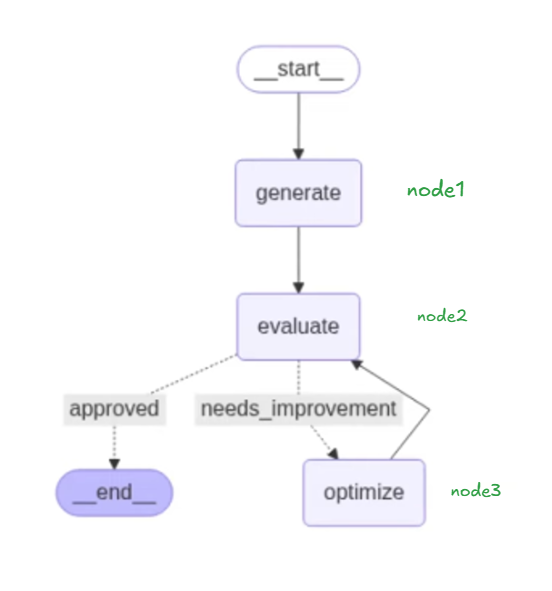

1.creating functions for the nodes

In [81]:
# function for generating the memes
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response}

In [82]:
# function for evaluation
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {
        'evaluation':response.evaluation,
        'feedback': response.feedback, 
    }

In [83]:
# function for implementing the logic of optimiser
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {
        'tweet': response, 
        'iteration': iteration,
        
    }

2.embediing the nodes into the graph

In [84]:
graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

step6:- adding edges

1. adding simple edges

In [85]:
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

2. adding conditional edge

In [86]:
# funtion that will handle the routing
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [87]:
# applying the conditonal edge
graph.add_conditional_edges(
    'evaluate', 
    route_evaluation, 
    {
        'approved': END, 
        'needs_improvement': 'optimize'}
        )

3.adding simple edge

In [88]:
graph.add_edge('optimize', 'evaluate')

step7:-compiling the graph

In [89]:
workflow = graph.compile()

step8:-visualizing the workflow

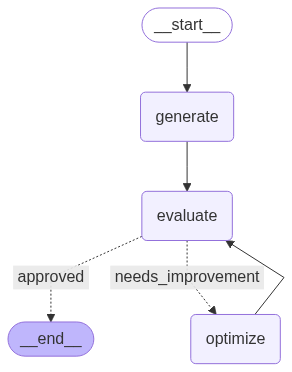

In [90]:
workflow

step9:-evaluating the workflow

In [91]:
initial_state = {
    "topic": "who are you?",
    "iteration": 1,
    "max_iteration": 5
}

In [92]:
result = workflow.invoke(initial_state)

In [93]:
result

{'topic': 'who are you?',
 'tweet': "I'm just a collection of browser tabs I'm too afraid to close, and I think that says everything you need to know.",
 'evaluation': 'approved',
 'feedback': "This tweet demonstrates strong relatability and a clever, concise metaphor for modern digital habits. Its humor stems from shared experience rather than a traditional punchline, making it highly shareable and likely to resonate with a broad audience. The formatting is impeccable, adhering to character limits and avoiding common pitfalls like Q&A or setup-punchline structures, which enhances its organic feel and virality potential. It's an effective piece of observational humor that captures a common sentiment without being cliché.",
 'max_iteration': 5}